# Question B3 (10 marks)

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [1]:
!pip install captum --user


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

1.First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [3]:
# YOUR CODE HERE

df = pd.read_csv('hdb_price_prediction.csv')

continuous_cols=["dist_to_nearest_stn", "dist_to_dhoby", "degree_centrality", "eigenvector_centrality", "remaining_lease_years", "floor_area_sqm"]
#categorical_cols=["month", "town", "flat_model_type", "storey_range"]

df_train = df[df["year"] <= 2019]
df_val = df[df["year"] == 2020]
df_test = df[df["year"] == 2021]

df_train = df_train[ ['resale_price'] + continuous_cols ]
df_val = df_val[ ['resale_price'] + continuous_cols ]
df_test = df_test[ ['resale_price'] + continuous_cols ]

print("Training data : ")#,df_train["year"].unique())
print(df_train.columns.tolist())
print("\n")
print("Validation data : ")#,df_val["year"].unique())
print(df_val.columns.tolist())
print("\n")
print("Testing data : ")#,df_test["year"].unique())
print(df_test.columns.tolist())

Training data : 
['resale_price', 'dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']


Validation data : 
['resale_price', 'dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']


Testing data : 
['resale_price', 'dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']


2.Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [4]:
# YOUR CODE HERE

target = ['resale_price']
batch_size = 64
num_epochs = 100
learning_rate = 0.001

from torch.utils.data import DataLoader, TensorDataset

# Convert dataframes to PyTorch tensors
X_train = torch.tensor(df_train[continuous_cols].values).float()
y_train = torch.tensor(df_train[target].values).view(-1, 1).float()

X_val = torch.tensor(df_val[continuous_cols].values).float()
y_val = torch.tensor(df_val[target].values).view(-1, 1).float()

X_test = torch.tensor(df_test[continuous_cols].values).float()
y_test = torch.tensor(df_test[target].values).view(-1, 1).float()

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
class B3_Model(nn.Module):
    def __init__(self, no_feature):
        super().__init__()
        self.lin1 = nn.Linear(no_feature, 5)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(5, 5)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(5, 5)
        self.relu3 = nn.ReLU()
        self.lin4 = nn.Linear(5, 1)

    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))
                         
model = B3_Model(no_feature=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
def train(model_inp, num_epochs, optimizer, loss_fn, dataloader):
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in dataloader:
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = loss_fn(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0


In [6]:
import os

def train_load_save_model(model_obj, model_path):
    if os.path.isfile(model_path):
        # load model
        print('Loading pre-trained model from: {}'.format(model_path))
        model_obj.load_state_dict(torch.load(model_path))
    else:    
        # train model
        train(model, num_epochs, optimizer, criterion, train_loader)
        print('Finished training the model. Saving the model to the path: {}'.format(model_path))
        torch.save(model_obj.state_dict(), model_path)
        

SAVED_MODEL_PATH = "saved_models/B3_Model"
train_load_save_model(model, SAVED_MODEL_PATH)

Epoch [1]/[100] running accumulative loss across all batches: 204929726038016.000
Epoch [21]/[100] running accumulative loss across all batches: 5713894164992.000
Epoch [41]/[100] running accumulative loss across all batches: 5393317090304.000
Epoch [61]/[100] running accumulative loss across all batches: 5114261176448.000
Epoch [81]/[100] running accumulative loss across all batches: 4563649503104.000
Finished training the model. Saving the model to the path: saved_models/B3_Model


C:\Users\65976\AppData\Roaming\Python\Python312\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


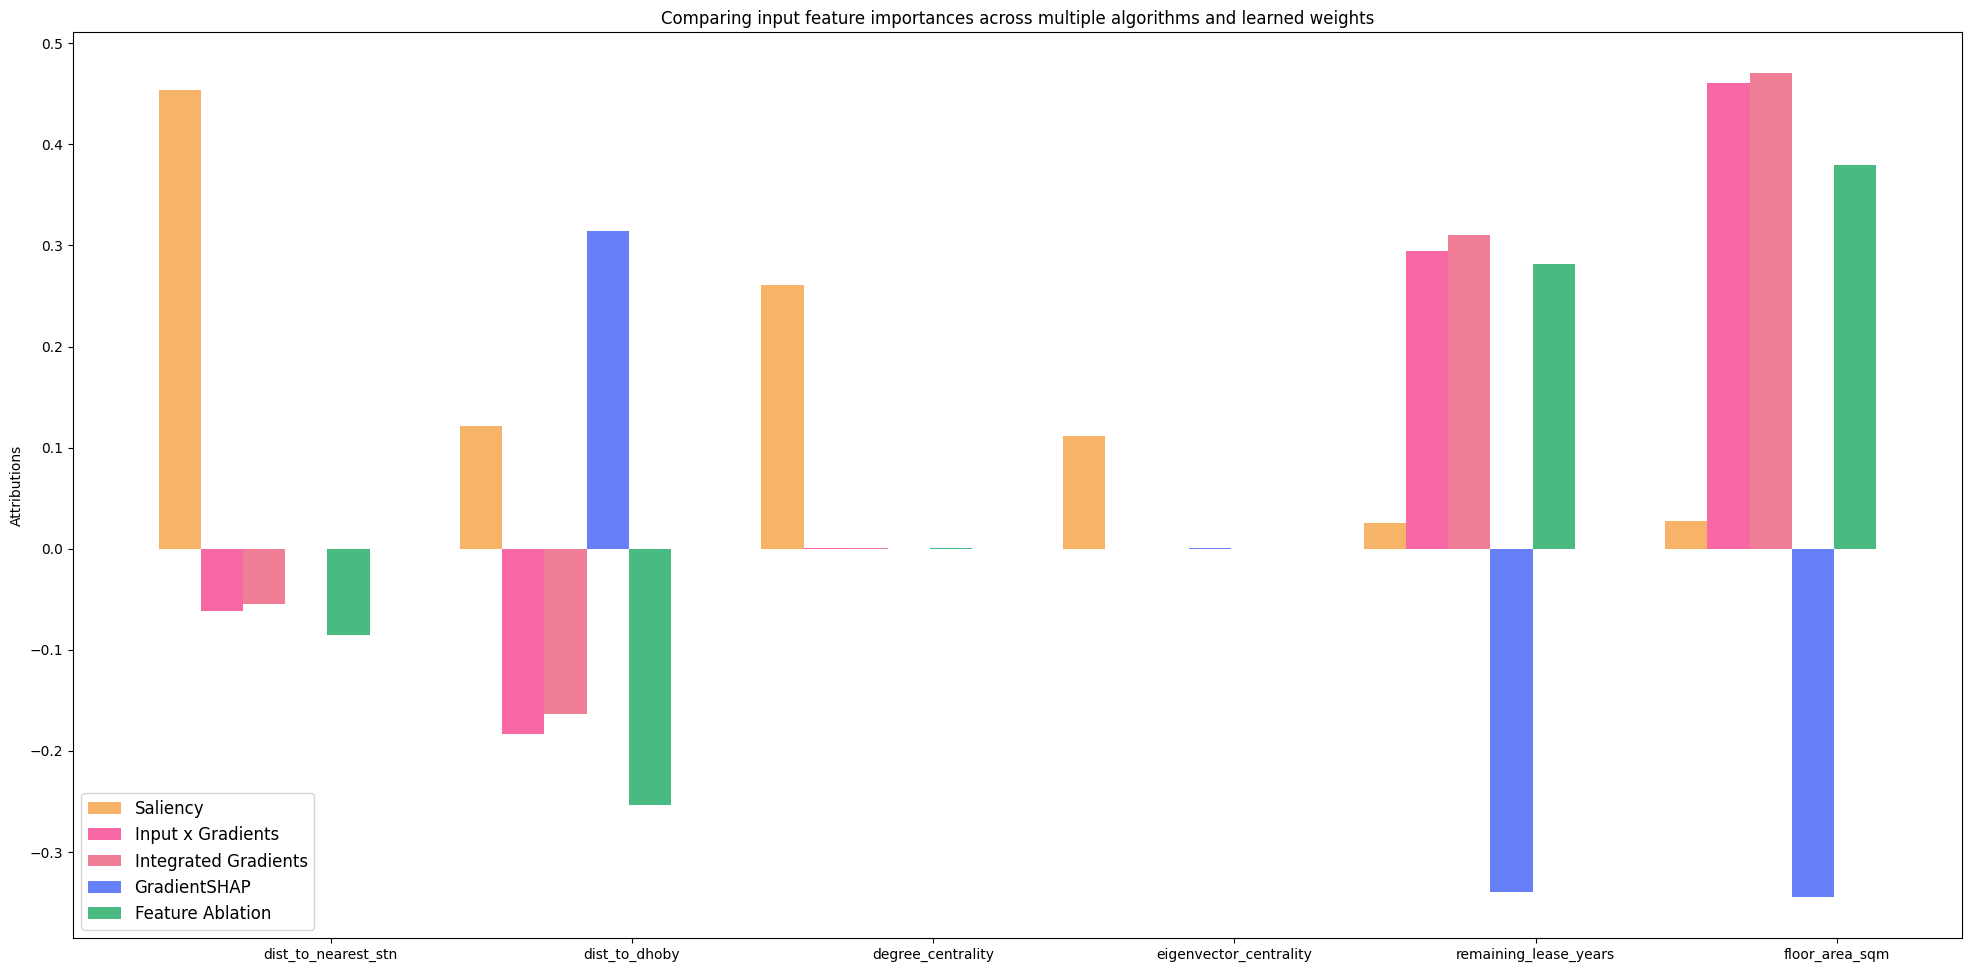

In [7]:
# Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation
import matplotlib.pyplot as plt


sal = Saliency(model)
ixg = InputXGradient(model)
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

sal_attr_test = sal.attribute(X_test[:1000])
ixg_attr_test = ixg.attribute(X_test[:1000])
ig_attr_test = ig.attribute(X_test[:1000], n_steps=50)

# Entire training set used for the distribution of baselines

gs_attr_test = gs.attribute(X_test[:1000], X_train)
fa_attr_test = fa.attribute(X_test[:1000])

# sal_attr_test = sal.attribute(X_test)
# ixg_attr_test = ixg.attribute(X_test)
# ig_attr_test = ig.attribute(X_test, n_steps=50)
# gs_attr_test = gs.attribute(X_test, X_train)
# fa_attr_test = fa.attribute(X_test)


feature_names = df_train.drop(target, axis=1).columns

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

sal_attr_test_sum = sal_attr_test.detach().numpy().sum(0)
sal_attr_test_norm_sum = sal_attr_test_sum / np.linalg.norm(sal_attr_test_sum, ord=1)

ixg_attr_test_sum = ixg_attr_test.detach().numpy().sum(0)
ixg_attr_test_norm_sum = ixg_attr_test_sum / np.linalg.norm(ixg_attr_test_sum, ord=1)

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

width = 0.14
legends = ['Saliency','Input x Gradients', 'Integrated Gradients', 'GradientSHAP', 'Feature Ablation']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, sal_attr_test_norm_sum, width, align='center', alpha=0.8, color='#f5a142')
ax.bar(x_axis_data + width, ixg_attr_test_norm_sum, width, align='center', alpha=0.8, color='#f5428d')
ax.bar(x_axis_data + 2 * width, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

3.Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [8]:
# YOUR CODE HERE

from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

standard_scaled_X_train = standard_scaler.fit_transform(X_train)
standard_scaled_X_train = torch.tensor(standard_scaled_X_train).float()
standard_scaled_X_val = standard_scaler.transform(X_val)
standard_scaled_X_val = torch.tensor(standard_scaled_X_val).float()

standard_scaled_X_test = standard_scaler.transform(X_test)
standard_scaled_X_test = torch.tensor(standard_scaled_X_test).float()

# Create data loaders
train_dataset = TensorDataset(standard_scaled_X_train, y_train)
val_dataset = TensorDataset(standard_scaled_X_val, y_val)
test_dataset = TensorDataset(standard_scaled_X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = B3_Model(standard_scaled_X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [9]:
SAVED_MODEL_PATH = "saved_models/B3_Model_Standard_Scaled"
train_load_save_model(model, SAVED_MODEL_PATH)

Epoch [1]/[100] running accumulative loss across all batches: 216351144001536.000
Epoch [21]/[100] running accumulative loss across all batches: 4383615827328.000
Epoch [41]/[100] running accumulative loss across all batches: 3894960285952.000
Epoch [61]/[100] running accumulative loss across all batches: 3777988663168.000
Epoch [81]/[100] running accumulative loss across all batches: 3660561295488.000
Finished training the model. Saving the model to the path: saved_models/B3_Model_Standard_Scaled


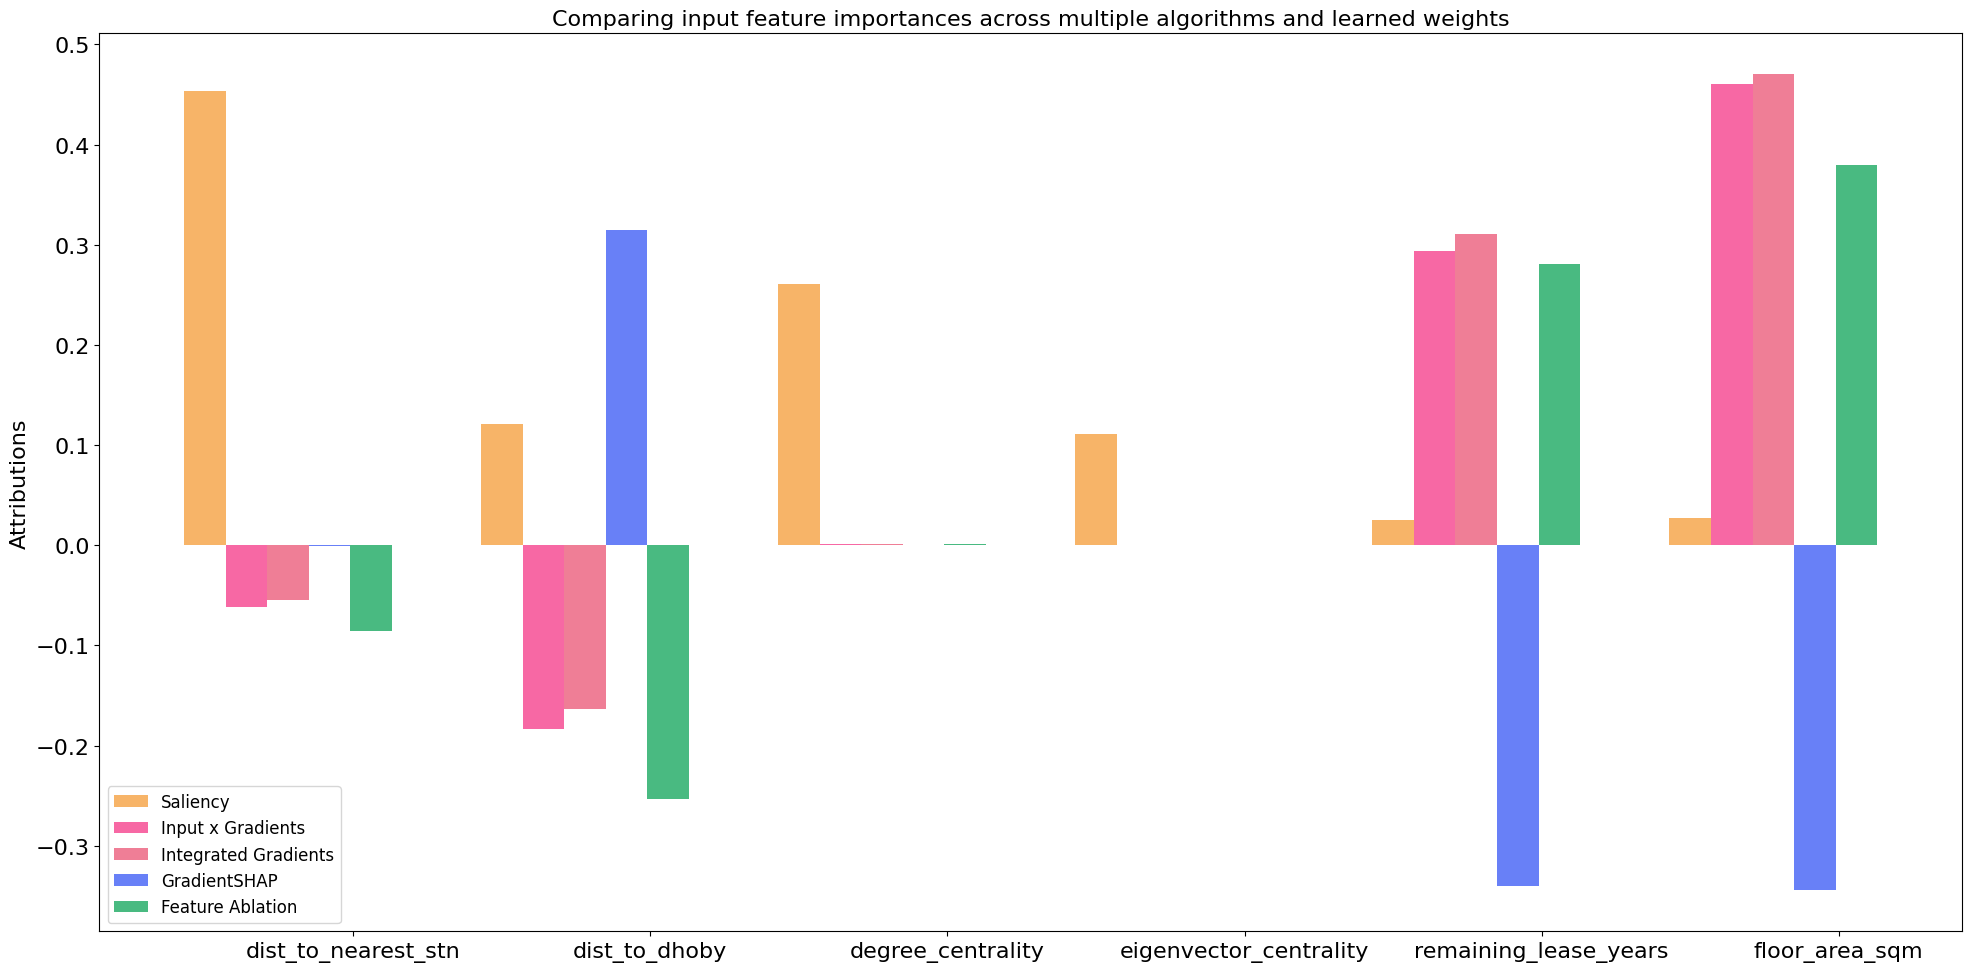

In [10]:

feature_names = df_train.drop(target, axis=1).columns

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

sal_attr_test_sum = sal_attr_test.detach().numpy().sum(0)
sal_attr_test_norm_sum = sal_attr_test_sum / np.linalg.norm(sal_attr_test_sum, ord=1)

ixg_attr_test_sum = ixg_attr_test.detach().numpy().sum(0)
ixg_attr_test_norm_sum = ixg_attr_test_sum / np.linalg.norm(ixg_attr_test_sum, ord=1)

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

width = 0.14
legends = ['Saliency','Input x Gradients', 'Integrated Gradients', 'GradientSHAP', 'Feature Ablation']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, sal_attr_test_norm_sum, width, align='center', alpha=0.8, color='#f5a142')
ax.bar(x_axis_data + width, ixg_attr_test_norm_sum, width, align='center', alpha=0.8, color='#f5428d')
ax.bar(x_axis_data + 2 * width, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

4.Why did Saliency produce scores similar to IG?


In [11]:
# YOUR ANSWER HERE

Saliency methods, like Gradient-based methods, often produce scores similar to Integrated Gradients (IG) when the input features have a linear relationship with the output or when the model architecture is relatively simple. This similarity occurs because both methods rely on the gradients of the model's output with respect to the input features. If the gradients are consistent across the input space, both methods are likely to produce similar attribution scores.

Consistency in attribution scores between Saliency and Integrated Gradients (IG) varies across different features for models trained on both scaled and non-scaled datasets.

Saliency solely provides the gradient of the output concerning the input, whereas Integrated Gradients calculates the accumulated gradients along a path from the baseline to the input, multiplied by the difference between them.

For Saliency and IG to yield similar results, the gradients along this path must be highly consistent, ensuring that the integral of the gradients in IG closely aligns with the direct gradients computed by Saliency.

In our scenario, setting the baseline to zero may deviate significantly from the input distribution of certain features, resulting in notable differences in attribution scores between Saliency and IG. However, with a more extensive dataset, this discrepancy might diminish.

Interestingly, scaling the data reduces the disparity between Saliency and IG values. This could be attributed to standardizing the input distribution, thereby bringing the baseline closer to it.

Moreover, non-linear relationships captured by IG may contribute to the discrepancy from Saliency values. For instance, while the resale price could exhibit a linear increase with floor area, its relationship with the distance to the nearest MRT station might be more than proportional.

5.Why did Input x Gradients give the same attribution scores as IG?


In [12]:
# YOUR ANSWER HERE

Input x Gradients (IxG) also relies on gradients like IG but combines them with the input values directly. This method essentially multiplies the gradients with the input values, which can produce similar attribution scores as IG under certain conditions. If the gradients and input values are relatively consistent across the input space, IxG can produce similar results to IG. Additionally, if the input values are scaled or normalized, IxG may produce even closer results to IG.


Input x Gradients (IxG) computes the gradient of the model output concerning each input feature and then multiplies it by the input values. Conversely, Integrated Gradients (IG) derives importance scores by accumulating gradients between the baseline value and the current input.

Although the attribution scores from both methods are highly similar, they are not identical for both models. This discrepancy likely arises because the difference between the baseline and input is minimal, resulting in insufficient gradient variation for the integral calculated by Integrated Gradients to significantly impact the outcome.

This phenomenon becomes more pronounced after scaling the dataset, as evidenced by the graphs. In this case, the attribution scores from IxG and IG shift from being similar to almost identical after scaling.